In [ ]:
'''
https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names
'''

In [ ]:
!apt-get install -y tesseract-ocr
!pip install pytesseract
!pip install opencv-python-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


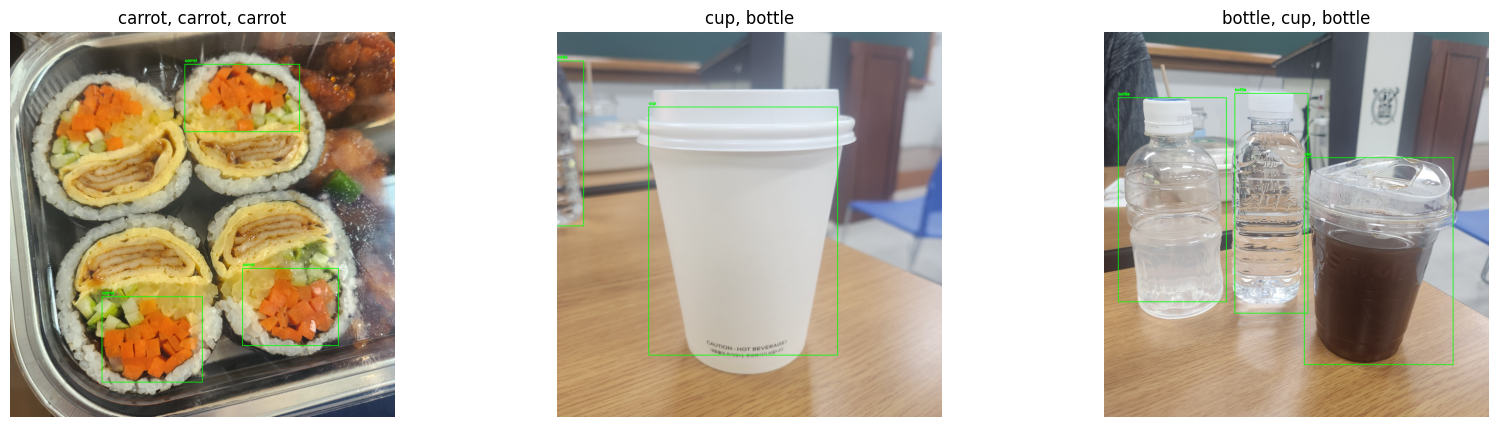

Image: image.jpg, Detected : carrot, carrot, carrot
Image: drink.jpg, Detected : cup, bottle
Image: drink2.jpg, Detected : bottle, cup, bottle


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# YOLOv3 모델과 구성 파일, 가중치 파일, 클래스 이름 파일 경로
cfg_path = "yolov3.cfg"
weights_path = "yolov3.weights"
names_path = "coco.names"

# COCO 클래스 이름 로드
with open(names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# 음식과 음료 클래스 필터링
food_and_drink_classes = [
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake", "bottle", "wine glass", "cup"
]

# 네트워크 설정
net = cv2.dnn.readNet(weights_path, cfg_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# 객체 탐지를 위한 설정
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# 이미지 전처리
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image {image_path}")
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    return image, blob

def get_detections(blob):
    net.setInput(blob)
    outs = net.forward(output_layers)
    return outs

def detect_objects(image_path):
    image, blob = preprocess_image(image_path)
    height, width, channels = image.shape
    outs = get_detections(blob)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
    indices = np.array(indices).flatten()

    detected_objects = []

    # 주로 화면에 보이는 물체 찾기
    for i in indices:
        label = classes[class_ids[i]]
        if label in food_and_drink_classes:
            detected_objects.append(label)
            x, y, w, h = boxes[i]
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image, detected_objects

# 여러 이미지에서 사물 감지 및 출력
image_dir = '/content/images'  # 사물 이미지가 저장된 디렉토리 경로로 수정
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]

detected_objects_dict = {}

# 모든 이미지를 한 줄에 작게 출력하고 결과 저장
plt.figure(figsize=(20, 5))
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    processed_image, detected_objects = detect_objects(image_path)

    detected_objects_dict[image_file] = detected_objects

    plt.subplot(1, len(image_files), idx + 1)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title(f"{', '.join(detected_objects)}")
    plt.axis("off")
plt.show()

# 인식된 사물 저장 결과 출력
for image_file, detected_objects in detected_objects_dict.items():
    print(f"Image: {image_file}, Detected : {', '.join(detected_objects)}")
